# Прогнозирование оттока клиентов для оператора связи

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, заказчику нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Цель проекта — разработать и обучить модель машинного обучения, которая будет прогнозировать отток клиентов компании. 


**Описание услуг:**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`) или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`:
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`:
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`:
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`:
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

### Импорт библиотек

In [1]:
# Стандартные библиотеки
import math
import numpy as np
import os
import re

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix

# Модули проекта
# функции для расчёта модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# функции для расчёта метрик
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,  roc_curve, recall_score, precision_score

# функции для масштабирования
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# функция для pipeline
from sklearn.pipeline import Pipeline

# функция для подготовки данных
from sklearn.compose import ColumnTransformer

# функция для разделения датасета на выборки
from sklearn.model_selection import train_test_split

# функция для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс поиска лучшей модели
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Сторонние библиотеки
import pandas as pd
import phik 

### Константы

In [2]:
# создание констант
RANDOM_STATE = 250825
TEST_SIZE = 0.25

### Функции

#### f_read_and_info

In [3]:
def f_read_and_info(filename, parse_dates=None):
    """
    Загружает CSV-файл из двух возможных путей и выводит информацию о DataFrame.

    Args:
        filename (str): имя файла
        parse_dates (list, optional): список колонок, которые нужно преобразовать в даты

    Returns:
        df (pd.DataFrame): Датафрейм
    """

    # путь
    pth1 = ''

    try:
        df = pd.read_csv(pth1+filename, parse_dates=parse_dates)
    except Exception as e:
        print(f'Файл не найден: {filename}')
        return None

    print(f'\n\n{'-'*25} Файл: {filename} {'-'*25}\n')

    # Переименование столбцов
    df.columns = [f_to_snake(col) for col in df.columns]

    # вывод первых строк
    display(df.head())

    # общая информация
    df.info()

    return df

#### f_to_snake

In [4]:
def f_to_snake(name):
    """
    Преобразует столбцы в змеиный регистр
    
    Args:
        name (str): исходное имя
    
    Returns:
        str: имя в snake_case
    """
    
    s1 = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()

#### f_drop_duplicates

In [5]:
def f_drop_duplicates(df, name='Таблица'):
    """
    Функция удаляет дублирующие записи

    Args:
        df (pd.DataFrame): Датафрейм с данными
        name (str): Имя датафрейма

    Returns:
       df (pd.DataFrame): Датафрейм с удаленными дублирующими данными
    """
    
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        df = df.drop_duplicates()
        print(f'{name:<25}: Дубликаты удалены ({duplicates})')
    else:
        print(f'{name:<25}: Дубликатов нет')
    return df

#### f_boxplot_histplot_describe

In [6]:
def f_boxplot_histplot_describe(df, active_clients=None):
    """
    Строит гистограмму и диаграмму размаха для всех количественных признаков.

    Args:
        df (pd.DataFrame): Исходный датафрейм
        active_clients (pd.Series, optional): Таблица с активными клиентами (по умолчанию не используется)

    Returns:
        pd.DataFrame: Числовое описание диаграммы размаха
    """

    # учет только активных клиентов, если список есть
    if active_clients is not None:
        df = df.query('id in @ active_clients') 

    # цветовая палитра
    color=sns.color_palette('GnBu')[5]
    color2=sns.color_palette('GnBu')[4]

    # количественные признаки
    num_col_names = df.select_dtypes(include=['number', 'datetime']).columns.drop('id', errors='ignore')

    columns_continuous = []
    columns_discrete = []

    # определение непрерывных и дискретных признаков
    for columns_i in num_col_names:
        if len(df[columns_i].unique()) <= 15 and df[columns_i].dtype in ['int64', 'Int', 'int32']:
            columns_discrete.append(columns_i)
        else:
            columns_continuous.append(columns_i)
    
    if len(columns_continuous) == 1:
        column = columns_continuous[0]
        data = df[column]

        fig, axes = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [3, 1]})   # сетка графиков
        
        # гистограмма
        sns.histplot(data, bins=40, kde=True, color=color, ax=axes[0], stat="percent")
        axes[0].set_title(f'\nРаспределение {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Доля наблюдений (%)') # Частота

        # диаграмма размаха
        sns.boxplot(data, orient='h', ax=axes[1], boxprops=dict(facecolor='none'))
        
        plt.tight_layout()
        plt.show()

        display(pd.DataFrame(df[column].describe()))
    
    if len(columns_discrete) == 1:
        column = columns_discrete[0]
        data = df[column]

        # Относительное распределение
        df_percent = df[column].value_counts(normalize=True) * 100
        
        # диаграмма столбчатая
        plt.figure(figsize=(8, 5))    
        sns.barplot(x=df_percent.index, y=df_percent.values, color=color2)
        plt.title(f'\nРаспределение {column}')
        plt.xlabel(column)
        plt.ylabel('Доля наблюдений (%)')
    
        plt.tight_layout()
        plt.show()


    if len(columns_continuous) > 1:
        
        num_cols = 2                                                                            # количество столбцов
        num_rows = math.ceil(len(columns_continuous) / num_cols)                                # количество строк
        fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(7 * num_cols, 5 * num_rows),  # сетка графиков
                                 gridspec_kw={'height_ratios': [3, 1] * num_rows})              # гистограмма 3 части, boxplot 1 часть
        axes = np.array(axes).reshape(num_rows * 2, num_cols)                                   # преобразование в одномерную структуру

        fig.suptitle('\n\nНепрерывные данные', fontsize=16)
        
        for i, column in enumerate(columns_continuous):
            row, col = divmod(i, num_cols)                                                      # определение позиции в сетке
            data = df[column]
            
            # гистограмма
            sns.histplot(data, bins=20, kde=True, color=color, ax=axes[row * 2, col], stat='percent')
            axes[row * 2, col].set_title(f'\nРаспределение {column}')
            axes[row * 2, col].set_xlabel(column)
            axes[row * 2, col].set_ylabel('Доля наблюдений (%)')
    
            # диаграмма размаха
            sns.boxplot(data, orient='h', ax=axes[row * 2 + 1, col], boxprops=dict(facecolor='none'))

        # удаление пустых графиков
        for k in range(i+col, len(axes)):
            fig.delaxes(axes[k, (col + 1) % num_cols])
            # print(row * 2 + col * 2)

        plt.tight_layout()
        plt.show()
        
        display(df[columns_continuous].describe())

    if len(columns_discrete) > 1:

        num_cols = 2                                                                            # количество столбцов
        num_rows = math.ceil(len(columns_discrete) / num_cols)                                  # количество строк
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(7 * num_cols, 5 * num_rows))      # сетка графиков
        axes = axes.flatten()                                                                   # преобразование в одномерную структуру 

        fig.suptitle('\nДискретные данные', fontsize=16)

        for i, column in enumerate(columns_discrete):
            df_percent = df[column].value_counts(normalize=True) * 100

            # диаграмма столбчатая
            sns.barplot(x=df_percent.index, y=df_percent.values, ax=axes[i], color=color2, alpha=1)
            axes[i].set_title(f'\nРаспределение {column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Доля наблюдений (%)')

        # удаление пустых графиков
        for k in range(i + 1, len(axes)):
            fig.delaxes(axes[k])

        plt.tight_layout()
        plt.show()

#### f_plot_pie

In [7]:
def f_plot_pie(df, active_clients=None, top_n = 5):
    """
    Строит круговую диаграмму для всех категориальных признаков.

    Args:
        df (pd.DataFrame): Исходный датафрейм
        active_clients (pd.Series, optional): Таблица с активными клиентами (по умолчанию не используется)
        top_n (int): Сколько самых частых категорий выводить на диаграмме.
    """

    # учет только активных клиентов, если список есть
    if active_clients is not None:
        df = df.query('id in @ active_clients') 

    # цветовая палитра
    color = sns.color_palette("GnBu_r")

    # категориальные признаки 
    cat_col_names = df.select_dtypes(include=['object']).columns                          # выдиление категориальных признаков

    num_cols = 2                                                                          # количество столбцов
    num_rows = math.ceil(len(cat_col_names) / num_cols)                                   # количество строк
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7 * num_cols, 4 * num_rows))    # сетка графиков
    axes = axes.flatten()                                                                 # преобразование в одномерную структуру 

    for i, column in enumerate(cat_col_names):
        ax = axes[i]

        # частоты
        vc = df[column].value_counts(dropna=False)
        top = vc.head(top_n)
        other_cnt = vc.iloc[top_n:].sum()
        plot_series = top.copy()
        if other_cnt:
            plot_series['all the other'] = other_cnt
            
        # круговая диаграмма
        ax.pie(plot_series.values,
               labels=[f'{column} ({count})' for column, count in plot_series.items()],
               autopct='%1.1f%%',
               colors=color,
               wedgeprops=dict(linewidth=1, edgecolor='white'),
               labeldistance=1.15,   # дальше от центра
               pctdistance=0.85,     # а проценты ближе к центру
               startangle=140
              )
        ax.set_title(f'Соотношение по критерию {column}')

    # удаление пустых графиков
    for k in range(i + 1, len(axes)):
        fig.delaxes(axes[k])
    
    plt.tight_layout()                                                                  # улучшение расположения графиков
    plt.show()

#### f_distribution_by_target_attribute

In [8]:
def f_distribution_by_target_attribute(df, target_column):
    """
    Строит диаграммы распределений в разбивке по целевому признаку 

    Args:
        df (pd.DataFrame): Исходный датафрейм
        target_column (str): Целевая переменная
    """
    
    # цветовая палитра
    custom_palette = [sns.color_palette("GnBu_r")[1], sns.color_palette("GnBu_r")[3]]
    color=sns.color_palette('GnBu')[5]
    color2=sns.color_palette('GnBu')[4]

    # определение количества уникальных значений целевого признака
    target_cnt = df[target_column].nunique()
    
    
    columns_continuous = []
    columns_discrete = []

    # определение непрерывных и дискретных признаков
    for columns_i in df.columns:
        if not(len(df[columns_i].unique()) <= 20 and df[columns_i].dtype in ['int64', 'Int', 'int32']) \
           and not(df[columns_i].dtype in ['object']):
            columns_continuous.append(columns_i)
        else:
            columns_discrete.append(columns_i)

    if len(columns_continuous) > 0:

        num_cols = 2                                                                                  # количество столбцов
        num_rows = math.ceil(len(columns_continuous) / num_cols)                                      # количество строк
        fig, axes = plt.subplots(num_rows * (target_cnt + 1), num_cols, 
                                 figsize=(6 * num_cols, 6 * num_rows),
                                 gridspec_kw={'height_ratios': ([3] + [1] * target_cnt) * num_rows})  # сетка графиков
        axes = np.array(axes).reshape(num_rows * (target_cnt + 1), num_cols)                          # преобразование в одномерную структуру

        for i, column in enumerate(columns_continuous):
            row, col = divmod(i, num_cols)                                                            # определение позиции в сетке
            hist_row = row * (target_cnt + 1)                                                         # определение позиции гистограммы
            
            # гистограмма
            sns.histplot(data=df, x=column, hue=target_column, kde=True, palette=custom_palette, ax=axes[hist_row, col], 
                         stat='density', common_norm=False)
            axes[hist_row, col].set_title(f'Распределение {column} в разбивке по {target_column}')
            axes[hist_row, col].set_ylabel('Доля наблюдений') # Частота
        
            # диаграмма размаха 
            quit_categories = sorted(df[target_column].unique())                                      # сортировка уникальных значений
            for j, quit_value in enumerate(quit_categories):
                sns.boxplot(data=df[df[target_column] == quit_value], 
                            x=column, ax=axes[hist_row + j + 1, col], 
                            boxprops=dict(facecolor='none'))
                axes[hist_row + j + 1, col].set_title(f'Диаграмма размаха {column} для {target_column} = {quit_value}')
        
        # удаление пустых графиков
        for k in range(i + 1, num_rows * num_cols):
            row, col = divmod(k, num_cols)
            hist_row = row * (target_cnt + 1)
            fig.delaxes(axes[hist_row, col])
            for t in range(target_cnt):
                fig.delaxes(axes[hist_row + t + 1, col])

        plt.tight_layout()
        plt.show()

    if len(columns_discrete) > 0:

        num_cols = 2                                                                                  # количество столбцов
        num_rows = math.ceil(len(columns_discrete) / num_cols)                                        # количество строк
        fig, axes = plt.subplots(num_rows, num_cols, 
                                 figsize=(6 * num_cols, 4 * num_rows))                                # сетка графиков
        axes = axes.flatten()                                                                         # преобразование в одномерную структуру

        fig.suptitle('Дискретные данные', fontsize=16, y=1.0)

        
        for i, column in enumerate(columns_discrete):

            df_percent = df.groupby(column)[target_column].value_counts(normalize=True).reset_index(name="percent")
            df_percent = df_percent.pivot_table(index=column, columns=target_column, values="percent", fill_value=0) * 100
    
            # диаграмма столбчатая
            df_percent.plot(kind="bar", stacked=False, color=custom_palette, ax=axes[i], alpha=0.8)
            axes[i].set_title(f'Распределение {column} в разбивке по {target_column}')
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Доля наблюдений (%)')
        
            if column == 'payment_method': 
                axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25)
            else:
                axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
        
        # удаление пустых графиков
        for i in range(i + 1, len(axes)):
            fig.delaxes(axes[i])
            
        plt.tight_layout()
        plt.show()

## Шаг 1. Загрузка данных

In [9]:
# чтение файла contract_new.csv
df_contract_new = f_read_and_info('contract_new.csv', parse_dates=['BeginDate'])

# чтение файла personal_new.csv
df_personal_new = f_read_and_info('personal_new.csv')

# чтение файла internet_new.csv
df_internet_new = f_read_and_info('internet_new.csv')

# чтение файла phone_new.csv
df_phone_new = f_read_and_info('phone_new.csv')



------------------------- Файл: contract_new.csv -------------------------



,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


------------------------- Файл: personal_new.csv -------------------------



,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


------------------------- Файл: internet_new.csv -------------------------



,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


------------------------- Файл: phone_new.csv -------------------------



,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Данные в целом хорошо подготовлены: в таблицах пропусков нет, типы данных соответствуют содержимому (кроме `total_charges` в `contract_new.csv`, который нужно привести к float). Дополнительно стоит проверить таблицы на дубликаты.

После минимальной предобработки таблицы будут готовы к анализу.

## Шаг 2. Исследовательский анализ и предобработка данных

### Предобработка данных

#### Преобразование типов данных

In [10]:
# преобразование total_charges в float
df_contract_new['total_charges'] = pd.to_numeric(df_contract_new['total_charges'], errors='coerce')

# получение информации о типе данных
df_contract_new['total_charges'].dtypes

dtype('float64')

In [11]:
# проверка пропусков
df_contract_new.query('total_charges.isna()')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Исходя из `begin_date` можно утверждать, что клиенты только заключили договор и еще не имеют общих расходом. Можно заполнить пропуски нулями.

In [12]:
# замена NAN на 0
df_contract_new.replace(np.nan, 0, inplace=True)

#### Обработка дублирующих записей

In [13]:
df_contract_new = f_drop_duplicates(df_contract_new, 'df_contract_new')
df_personal_new = f_drop_duplicates(df_personal_new, 'df_personal_new')
df_internet_new = f_drop_duplicates(df_internet_new, 'df_internet_new')
df_phone_new    = f_drop_duplicates(df_phone_new, 'df_phone_new')

df_contract_new          : Дубликатов нет
df_personal_new          : Дубликатов нет
df_internet_new          : Дубликатов нет
df_phone_new             : Дубликатов нет


In [14]:
# Проверка дубликатов по customer_id
print(f'df_contract_new: {df_contract_new['customer_id'].duplicated().sum()}')
print(f'df_personal_new: {df_personal_new['customer_id'].duplicated().sum()}')
print(f'df_internet_new: {df_internet_new['customer_id'].duplicated().sum()}')
print(f'df_phone_new   : {df_phone_new['customer_id'].duplicated().sum()}')

df_contract_new: 0
df_personal_new: 0
df_internet_new: 0
df_phone_new   : 0


#### Добавление целевого признака и дополнительное преобразование

Для моделирования необходимо создать столбец с целевой переменной, которая показывает, ушёл клиент или остаётся действующим пользователем.

In [15]:
# создание целевого признака
df_contract_new['churn'] = np.where(df_contract_new['end_date'] == 'No', 0, 1)
df_contract_new.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn
2569,8237-ULIXL,2014-02-01,No,Two year,No,Credit card (automatic),24.85,1789.20,0
1857,9359-JANWS,2014-09-01,No,Two year,No,Credit card (automatic),58.90,3981.64,0
91,2424-WVHPL,2020-01-01,No,Month-to-month,No,Electronic check,74.70,79.93,0
796,2040-OBMLJ,2017-07-01,No,One year,No,Credit card (automatic),81.70,2532.70,0
3904,4803-LBYPN,2017-04-01,No,Month-to-month,No,Mailed check,20.80,707.20,0


Для получения распределения по `end_date` следует удалить текст "No" и преобразовать в тип datetime64

In [16]:
# замена "No" на NaT и приведение столбца к формату datetime
df_contract_new['end_date'] = pd.to_datetime(df_contract_new['end_date'].replace('No', pd.NaT))
df_contract_new['end_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: end_date
Non-Null Count  Dtype         
--------------  -----         
1101 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 55.2 KB


Для удобства построения диаграмм лучше преобразовать числовые признаки, которые носят категориальный смысл.

In [17]:
df_personal_new['senior_citizen'] = df_personal_new['senior_citizen'].replace({0: 'No', 1: 'Yes'})
df_personal_new.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


### Исследовательский анализ данных

In [18]:
# установка customer_id как индекс
df_contract_new.set_index("customer_id", inplace=True)
df_personal_new.set_index("customer_id", inplace=True)
df_internet_new.set_index("customer_id", inplace=True)
df_phone_new.set_index("customer_id", inplace=True)

#### Данные `df_contract_new`

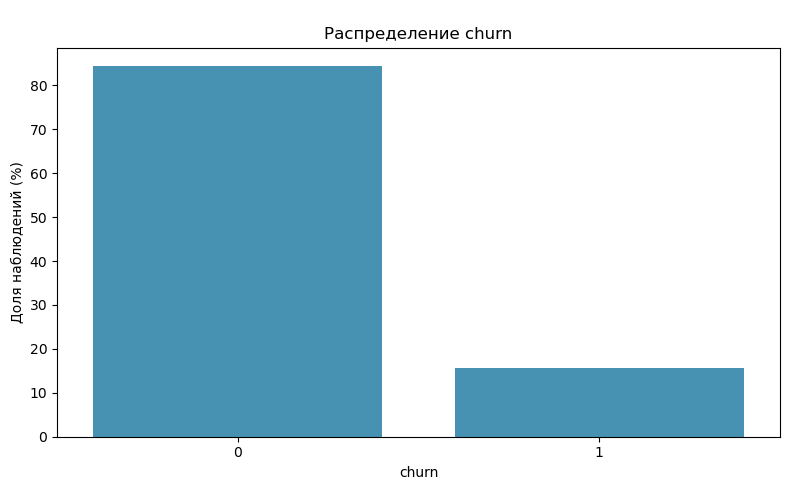

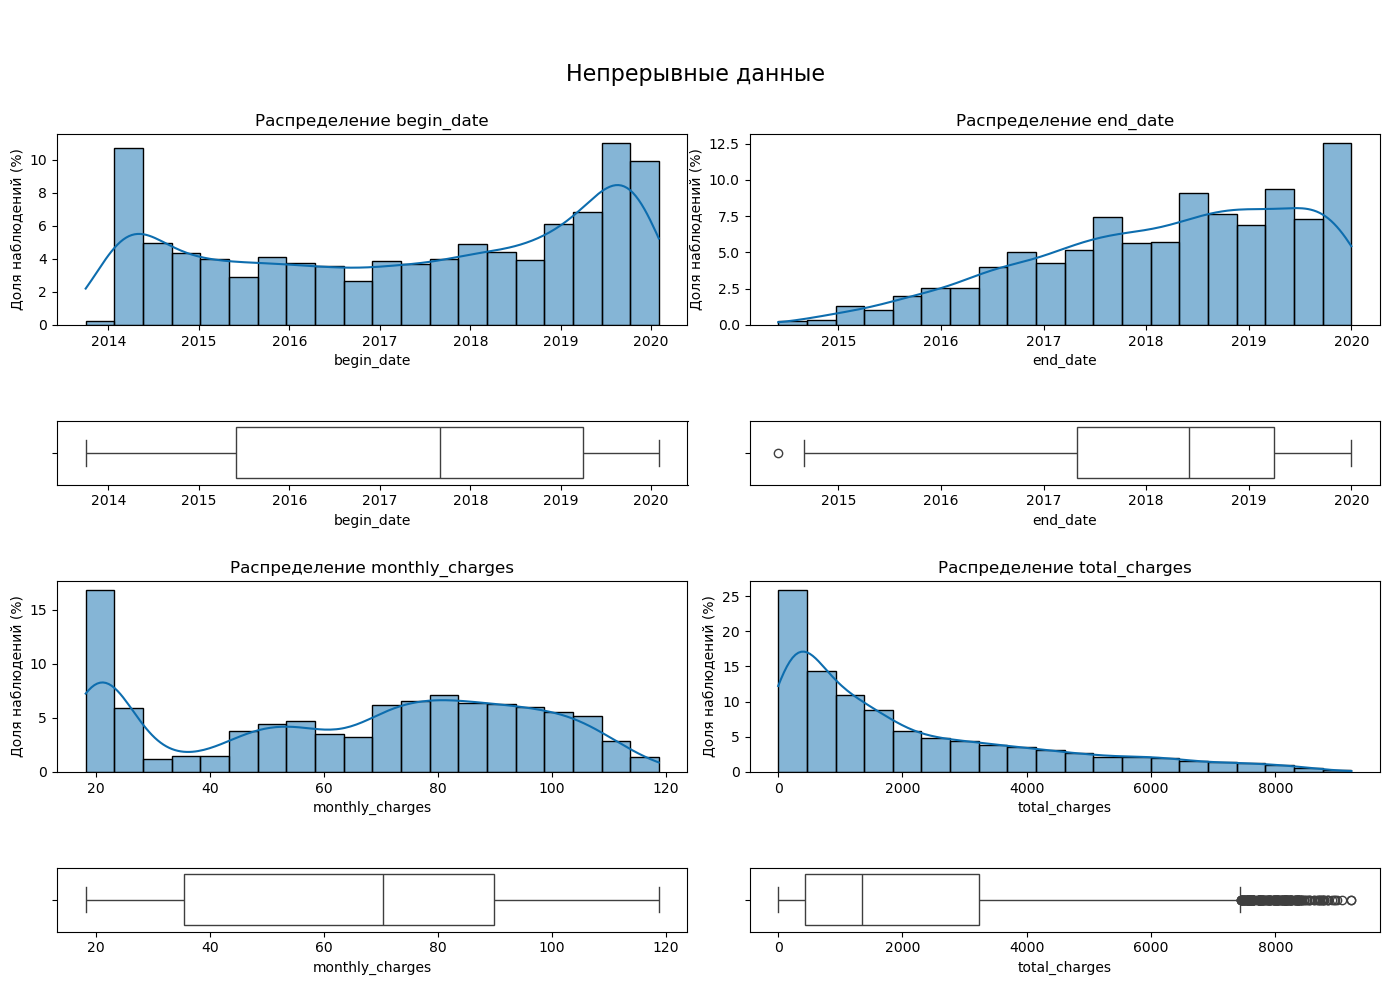

,begin_date,end_date,monthly_charges,total_charges
count,7043,1101,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2115.312885
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,436.750000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1343.350000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3236.690000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000
std,NaN,NaN,30.090047,2112.742814


In [19]:
# гистограмма и диаграмма размаха для всех количественных признаков 
f_boxplot_histplot_describe(df_contract_new)

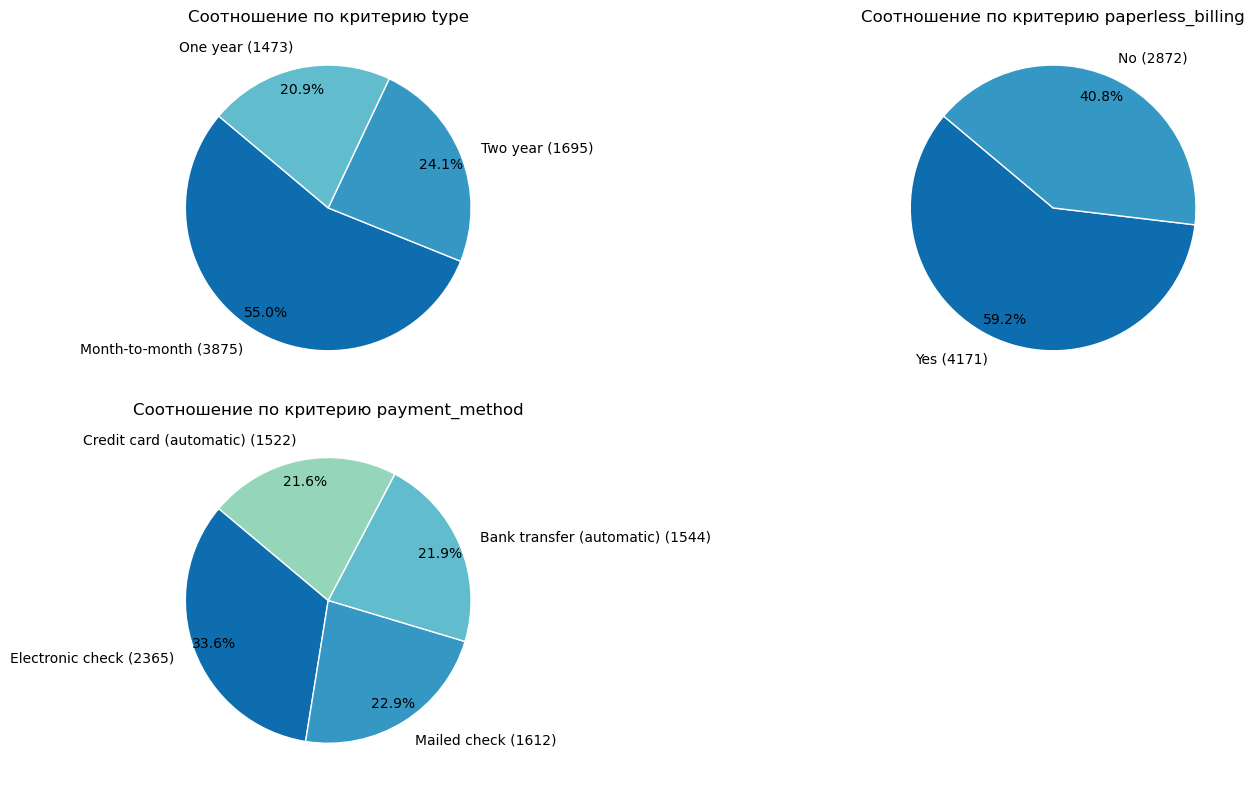

In [20]:
# круговые диаграммы категориальных признаков
f_plot_pie(df_contract_new)

- `churn`: наблюдается выраженный дисбаланс классов (~85% действующих клиентов против ~15% ушедших). Это важно учитывать при обучении моделей
- `begin_date`: распределение относительно равномерное, но с 2019 года заметен рост числа новых клиентов
- `end_date`: показывает постепенный рост оттока
- `total_charges`: распределение сильно скошено вправо, те большинство клиентов имеют низкие общие расходы, но есть длинный хвост
- `type`: более половины клиентов (55%) имеют ежемесячный тип оплаты

#### Данные `df_personal_new`

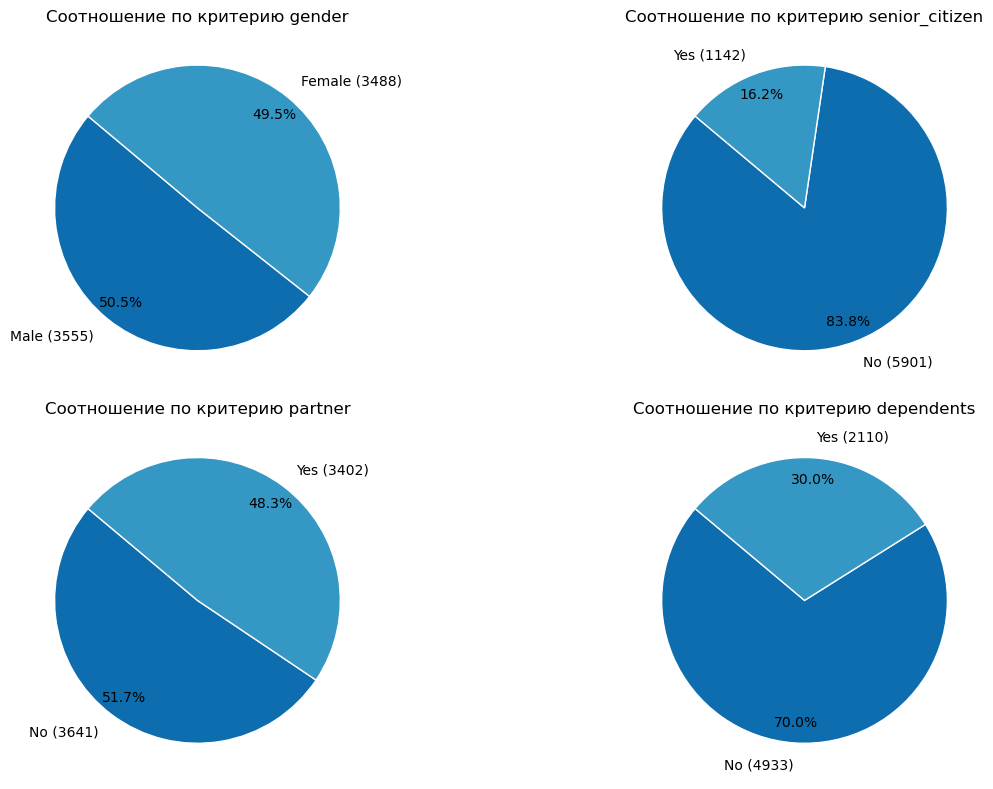

In [21]:
# круговые диаграммы категориальных признаков
f_plot_pie(df_personal_new)

- `gender`: распределение клиентов по полу практически равномерное — 50,5% мужчины и 49,5% женщины. Гендерного перекоса в выборке нет
- `senior_citizen`: только 16% клиентов — пенсионеры, большинство (84%) — не пенсионеры
- `partner`: около 48% клиентов имеют партнёра, 52% — нет. Распределение достаточно сбалансированное
- `dependents`: у 30% клиентов есть дети, у 70% — нет

#### Данные `df_internet_new`

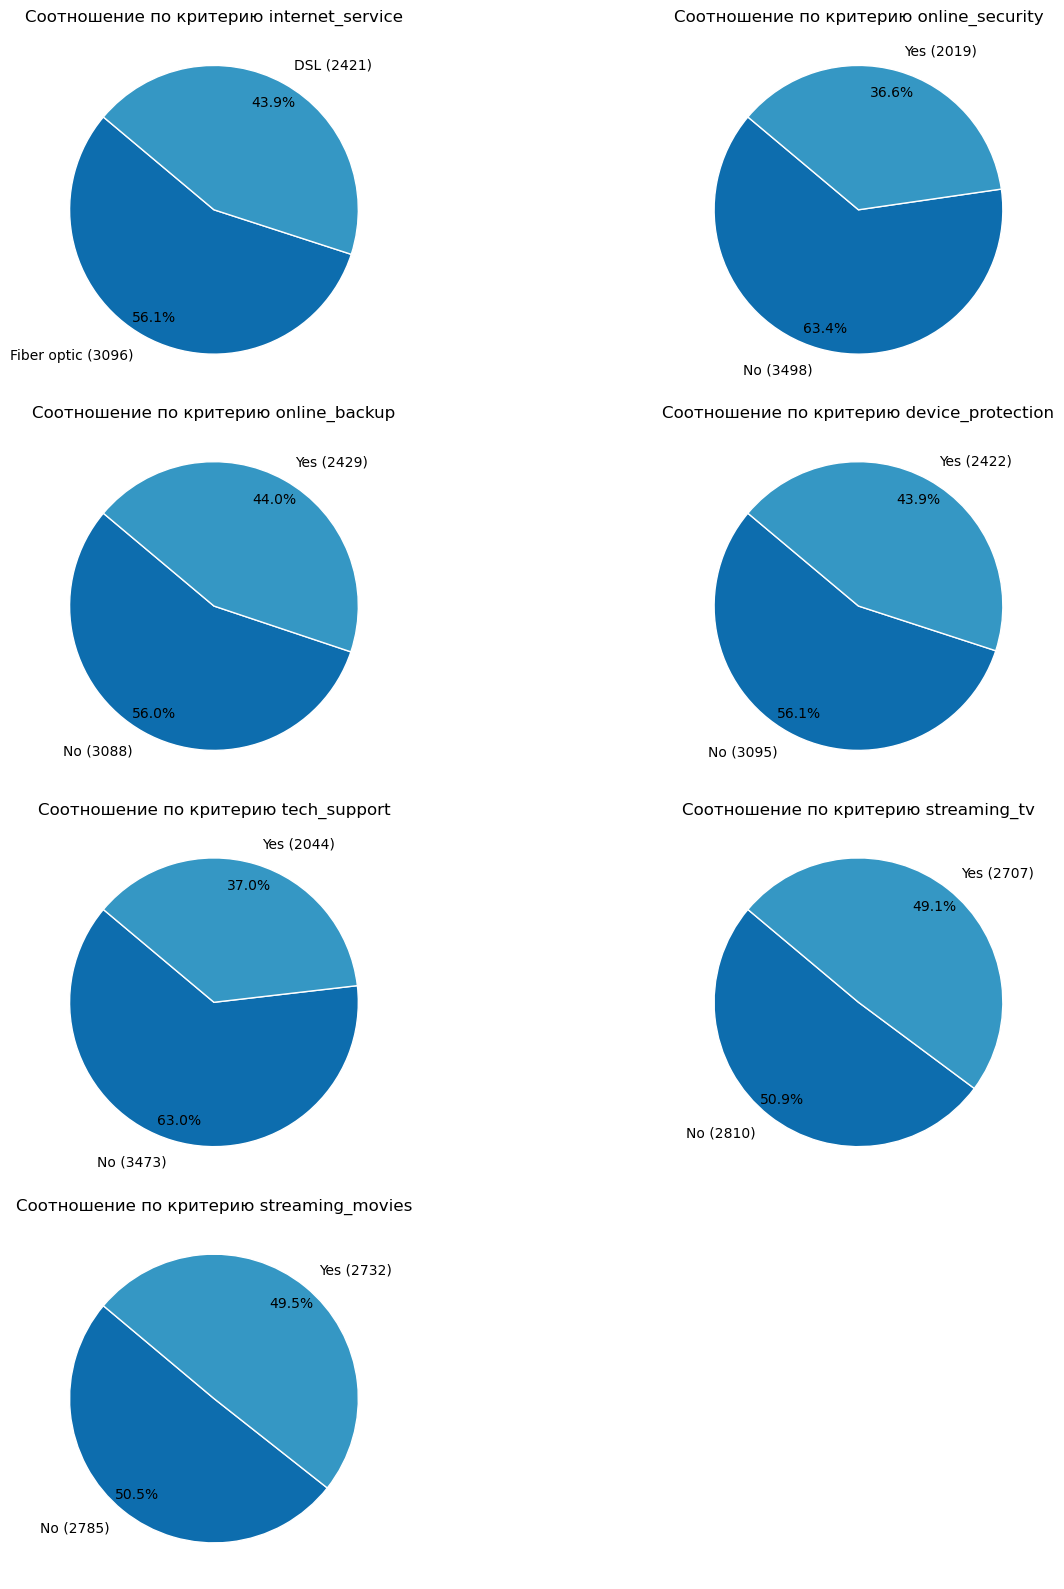

In [22]:
# круговые диаграммы категориальных признаков
f_plot_pie(df_internet_new)

- `internet_service`; `online_backup`; `device_protection`; `streaming_tv`; `streaming_movies`: распределение клиентов по этим признакам примерно равномерное
- `online_security`: только 37% клиентов пользуются услугой блокировки опасных сайтов, 63% отказались
- `tech_support`: услуга технической поддержки подключена лишь у 37% клиентов, 63% обходятся без неё


#### Данные `df_phone_new`

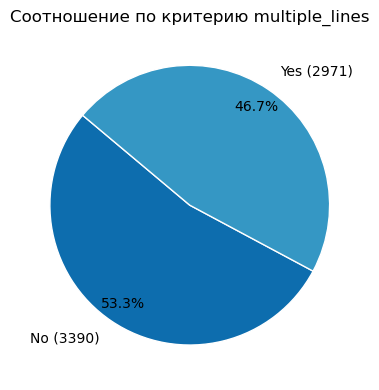

In [23]:
# круговые диаграммы категориальных признаков
f_plot_pie(df_phone_new)

- `multiple_lines`: распределение почти равномерное, без сильного перекоса

## Шаг 3. Объединение данных

In [24]:
# объединение данных
df = df_contract_new.merge(df_personal_new, how='left', on='customer_id') \
                    .merge(df_internet_new, how='left', on='customer_id') \
                    .merge(df_phone_new, how='left', on='customer_id')

df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


In [25]:
# получение общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   churn              7043 non-null   int32         
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14

После объединения всех таблиц в единый датафрейм в некоторых признаках появились пропуски. Это связано с тем, что не все клиенты подключили интернет и не все пользуются услугами телефонии. Поэтому пропуски логично будет заменить на «No», чтобы модели могли корректно использовать эту информацию при обучении модели

## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

### Предобработка данных

#### Добавление новых признаков

In [26]:
# Добавление новых признаков

# срок обслуживания
df['service_period'] = (df['end_date'].fillna('2020-02-01') - df['begin_date']).dt.days

# наличие интернета
df['has_internet'] = np.where(df['internet_service'].isna(), 'No', 'Yes')

# наличие телефона
df['has_phone'] = np.where(df['multiple_lines'].isna(), 'No', 'Yes')

# наличие семьи
df['has_family'] = np.where((df['partner'] == 'Yes') | (df['dependents'] == 'Yes'), 'Yes', 'No')

In [27]:
# удаление ненужный признаков 
df = df.drop(['begin_date', 'end_date'], axis=1)

In [28]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,gender,senior_citizen,partner,dependents,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,service_period,has_internet,has_phone,has_family
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,No,Yes,No,...,Yes,No,No,No,No,NaN,31,Yes,No,Yes
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,Male,No,No,No,...,No,Yes,No,No,No,No,1036,Yes,Yes,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,No,No,No,...,Yes,No,No,No,No,No,123,Yes,Yes,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,No,No,No,...,No,Yes,Yes,No,No,NaN,1371,Yes,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,No,No,No,...,No,No,No,No,No,No,153,Yes,Yes,No


#### Обработка пропусков

In [29]:
# заполнения признака multiple_lines на "missing", чтобы не потерять логический смысл No - подключение телефона к одной линии
df['multiple_lines'] = df['multiple_lines'].fillna('missing')

# замена пропусков на No
df = df.fillna('No')

In [30]:
# подсчет пропусков
df.isna().sum()

type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
service_period       0
has_internet         0
has_phone            0
has_family           0
dtype: int64

### Исследовательский анализ данных

#### Распределения признаков в разбивке по целевому признаку

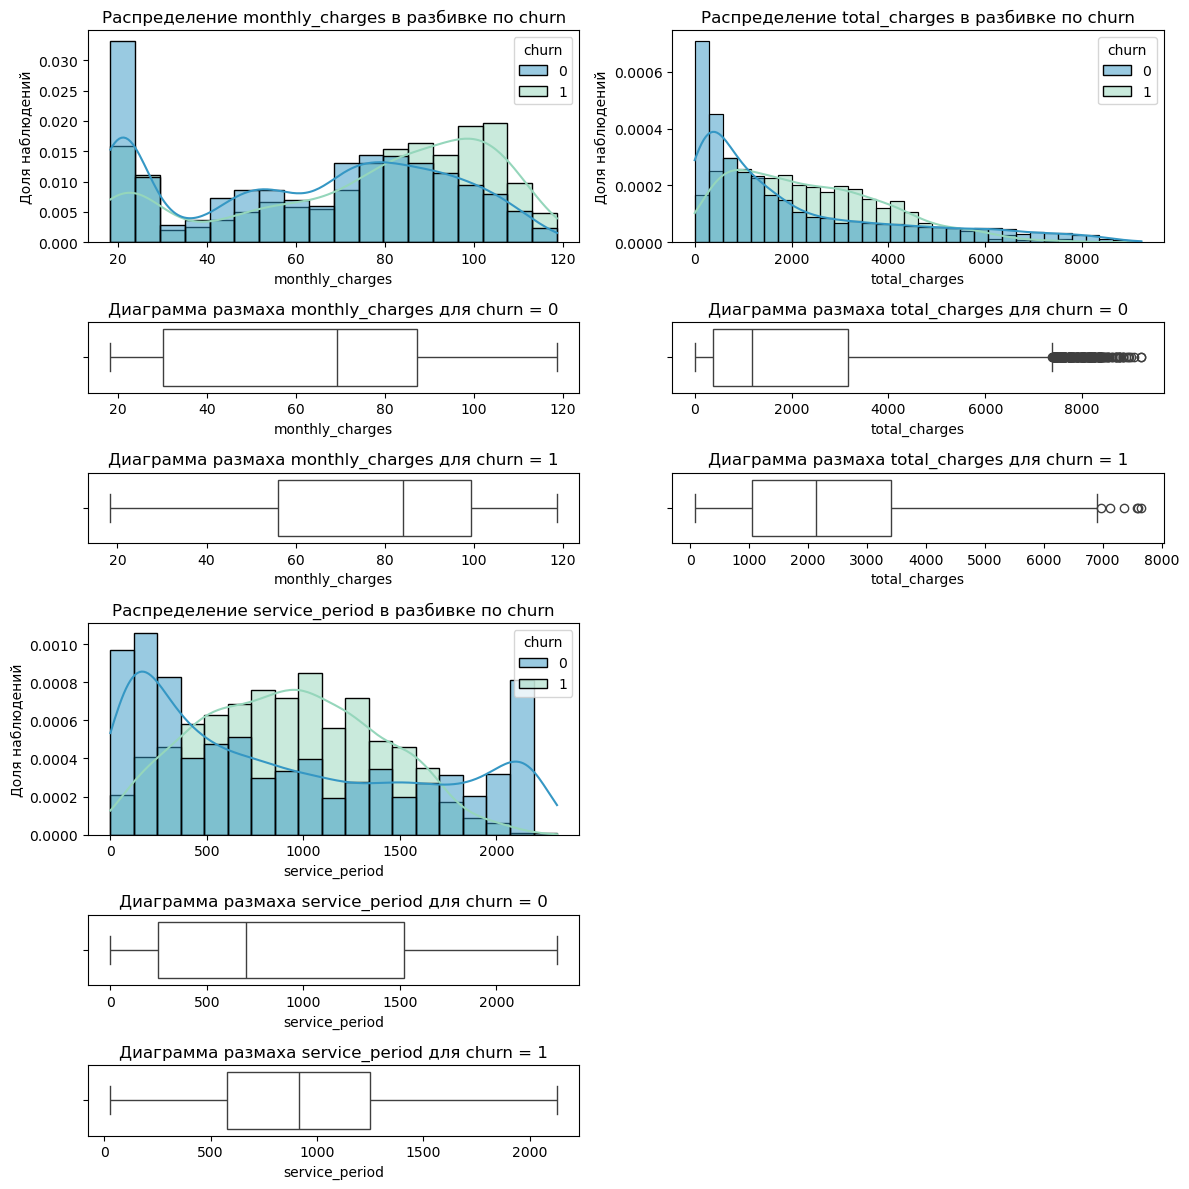

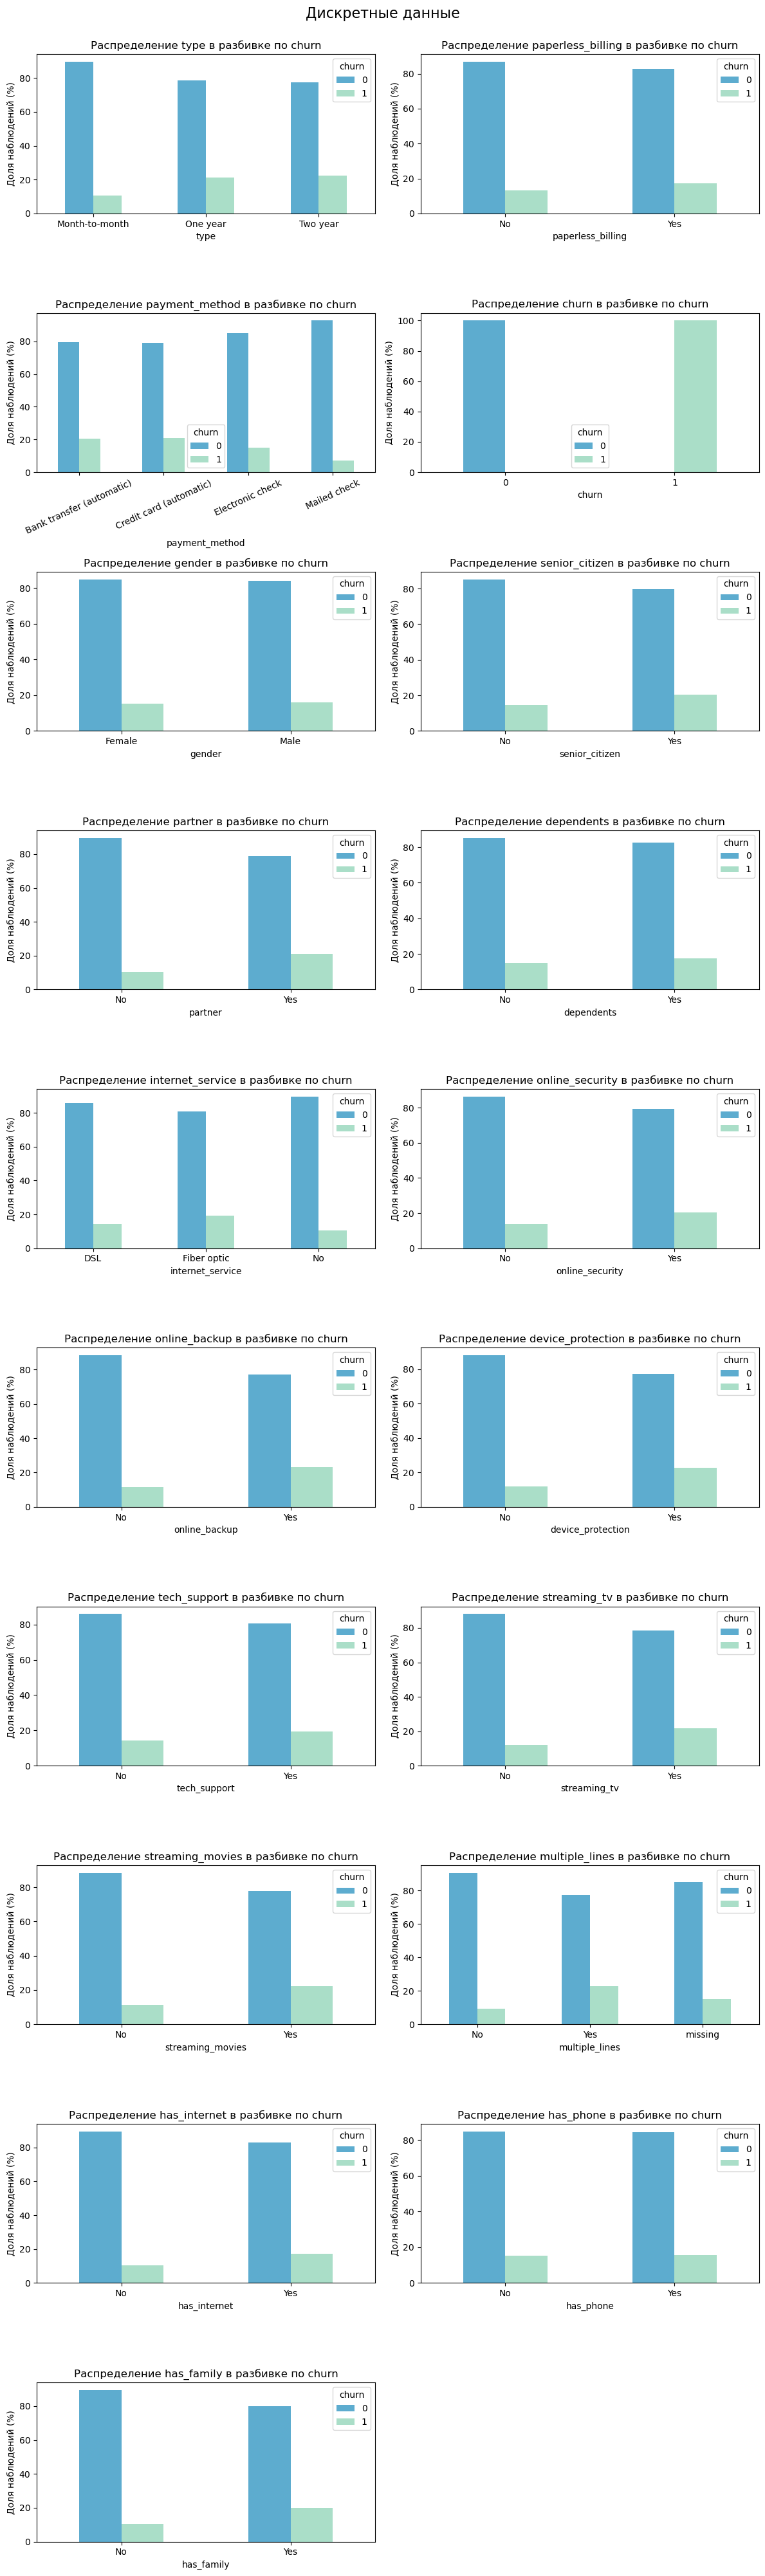

In [31]:
# диаграммы распределений в разбивке по quit
f_distribution_by_target_attribute(df, 'churn')


- `monthly_charges`: у ушедших клиентов ежемесячные платежи чаще выше (медиана больше), чем у оставшихся
- `total_charges`: ушедшие клиенты в среднем успели потратить больше, чем оставшиеся
- `service_period`: у ушедших клиентов медианный срок обслуживания больше (примерно на 200 дн.), но разброс меньше
- `type`: наименьший отток наблюдается у клиентов с ежемесячной оплатой
- `payment_method`: наименьший отток среди клиентов, которые используют тип оплаты Mailed check
- `senior_citizen`: пенсионеры уходят чаще, чем молодые клиенты
- `partner`: клиенты с партнерами чаше уходят
- `internet_service`: пользователи с оптоволоконным интернетом уходят заметно чаще
- `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`: клиенты, которые подключили дополнительные услуги, чаше уходят
- `multiple_lines`: наличие нескольких линий связано с немного более высоким уровнем оттока 

* `has_internet`: отток выше среди клиентов с интернетом
* `has_phone`: существенной разницы нет
* `has_family`: у клиентов с семьей вероятность оттока заметно выше


#### Корреляционный анализ

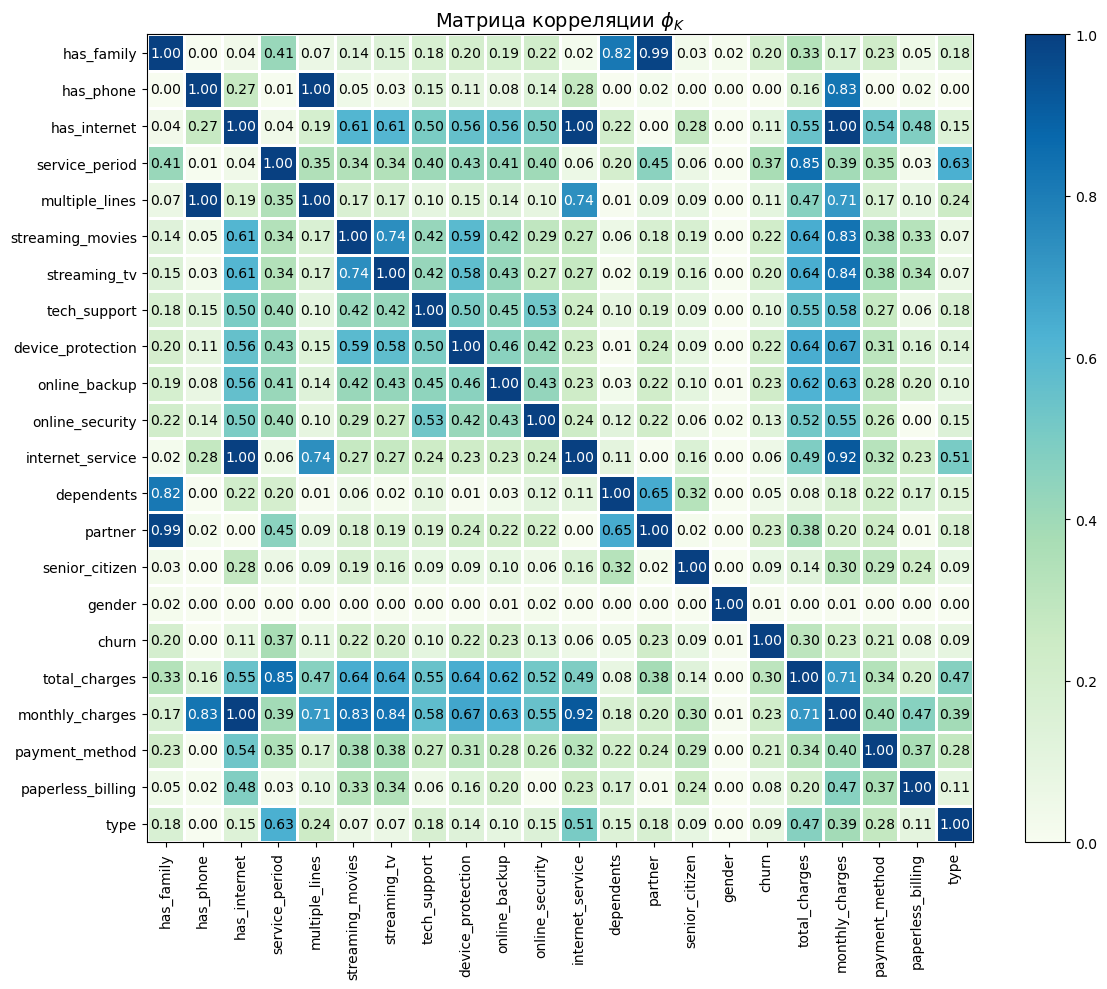

In [32]:
# Коэффициент корреляции Фи

interval_cols = ['monthly_charges', 'total_charges', 'service_period'] 

phik_overview = df.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, 
    color_map=sns.color_palette("GnBu", as_cmap=True),
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=1,
    figsize=(12, 10)
)

Корреляция с целевым признаком `churn`: 
- `service_period` (0.37) и `total_charges` (0.3) - показывают умеренную корреляция с `churn`
- С признаками `has_phone` и `gender` корреляция отсутствует, их можно удалить
- Прочие признаки имеют слабую или очень слабую корреляцию с `churn`

Добавленные признаки:
- `has_family`: лучше использовать исходные признаки `partner` и `dependents`, так как по отдельности они информативнее
- `has_phone`: вообще не коррелирует с `churn`, можно удалять
- `has_internet`: лучше коррелирует с `churn`, чем `internet_service`, но при этом имеет мультиколлинеарность с `monthly_charges`, который более ценен для прогнозирования. Поэтому следует удалить `has_internet` 
- `service_period`: имеет умеренную корреляцию с `churn`, можно оставить

Прочие заметные зависимости:
- Между `monthly_charges` и `internet_service` мультиколлинеарная связь, следует удалить один признак  


## Шаг 5. Подготовка данных

In [33]:
# выделение в отдельные переменные целевого и входных признаков
X = df.drop(['churn', 'has_internet', 'has_phone', 'has_family', 'internet_service', 'gender'], axis=1)
y = df.churn

# списки с названиями признаков
cat_columns = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'online_security', 
               'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
num_columns = ['monthly_charges', 'total_charges', 'service_period']

# перевод категориальных колонок в тип category
X[cat_columns] = X[cat_columns].astype('category')

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE, 
    shuffle=True, 
    stratify=y)

In [34]:
# Подготовка данных 

ohe_pipe = Pipeline(
    [('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

num_pipe = Pipeline(
    [('imputer', SimpleImputer(strategy='median')),
     ('num', StandardScaler())]
)

ord_pipe = Pipeline(
    [('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))]
)


In [35]:
# Поиск лучшей модели

fin_results = [] 

def best_search(model, param, n_iter=10):

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param,
        cv=5,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_iter=n_iter,
        n_jobs=-1
        )

    search.fit(X_train, y_train)
    
    cv_res = search.cv_results_
    cv_res_index = search.best_index_
    time_fit_mean = cv_res['mean_fit_time'][cv_res_index]           # среднее время обучения модели 
    time_score_mean = cv_res['mean_score_time'][cv_res_index]       # среднее время предсказаний и расчета метрики
    print(f'Среднее время обучения лучшей модели: {time_fit_mean:.4f} cек.')
    print(f'Среднее время предсказания и расчёта метрики лучшей модели: {time_score_mean:.4f} cек.')
    
    metric_train = search.best_score_
    print(f'Метрика ROC-AUC лучшей модели на кросс-валидации: {metric_train:.4f}')

    if hasattr(model, "named_steps"):
        name_model = list(model.named_steps.values())[-1].__class__.__name__
    else: 
        name_model =  model.__class__.__name__

    fin_list = [name_model, time_fit_mean, time_score_mean, metric_train]
    fin_results.append(fin_list)

    print('Параметры:', search.best_params_)

    return search

## Шаг 6. Обучение моделей машинного обучения

### LogisticRegression

In [36]:
# Обучение модели LogisticRegression

prep = ColumnTransformer(
    [('ohe', ohe_pipe, cat_columns),
     ('num', num_pipe, num_columns)], 
     remainder='drop'
)

lr_model = Pipeline([
    ('preprocessor', prep),
    ('model', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

lr_param = {
    'model__C': np.arange(0.01, 10, 0.1),
    'model__max_iter': np.arange(100, 1500, 100)
}

lr_best_model = best_search(lr_model, lr_param, n_iter=30)
lr_best_model

# 0.7664

Среднее время обучения лучшей модели: 0.0453 cек.
Среднее время предсказания и расчёта метрики лучшей модели: 0.0169 cек.
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.7664
Параметры: {'model__max_iter': 900, 'model__C': 0.6100000000000001}


,estimator,Pipeline(step...ate=250825))])
,param_distributions,"{'model__C': array([0.01, ... 9.91]), 'model__max_iter': array([ 100, ..., 1300, 1400])}"
,n_iter,30
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,250825
,error_score,nan


### RandomForestClassifier

In [37]:
# Обучение модели RandomForestClassifier

prep = ColumnTransformer(
    [('ord', ord_pipe, cat_columns)], 
     remainder='passthrough'
)

rfr_model = Pipeline([
    ('preprocessor', prep),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

rfr_param = {
    'model__n_estimators': np.arange(50, 500, 50),
    'model__max_depth': range(1, 40),
    'model__min_samples_split': range(2, 20),
    'model__min_samples_leaf': range(1, 20)
}

rfr_best_model = best_search(rfr_model, rfr_param, n_iter=20)
rfr_best_model

# 0.8343

Среднее время обучения лучшей модели: 1.0712 cек.
Среднее время предсказания и расчёта метрики лучшей модели: 0.0494 cек.
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.8343
Параметры: {'model__n_estimators': 200, 'model__min_samples_split': 3, 'model__min_samples_leaf': 13, 'model__max_depth': 36}


,estimator,Pipeline(step...ate=250825))])
,param_distributions,"{'model__max_depth': range(1, 40), 'model__min_samples_leaf': range(1, 20), 'model__min_samples_split': range(2, 20), 'model__n_estimators': array([ 50, 1...50, 400, 450])}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,250825
,error_score,nan


### LGBMClassifier

In [38]:
# Обучение модели LGBMClassifier

lgbmr_model = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced', verbosity=-1)

lgbmr_param =  {
    'n_estimators': np.arange(25, 800, 25), 
    'learning_rate': np.arange(0.05, 0.30, 0.05),
    'max_depth': range(5, 40)
}

lgbmr_best_model = best_search(lgbmr_model, lgbmr_param, n_iter=20)
lgbmr_best_model

# 0.8896

Среднее время обучения лучшей модели: 6.4439 cек.
Среднее время предсказания и расчёта метрики лучшей модели: 0.0138 cек.
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.8896
Параметры: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.15000000000000002}


,estimator,LGBMClassifie... verbosity=-1)
,param_distributions,"{'learning_rate': array([0.05, ..., 0.2 , 0.25]), 'max_depth': range(5, 40), 'n_estimators': array([ 25, ...25, 750, 775])}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,250825
,error_score,nan


## Шаг 7. Выбор лучшей модели

### Анализ моделей

In [39]:
# Анализ моделей
columns = ['model_names', 'time fit (mean)', 'time score (mean)', 'ROC-AUC (CV)']
table_fin_results = pd.DataFrame(fin_results, columns=columns)
table_fin_results

,model_names,time fit (mean),time score (mean),ROC-AUC (CV)
0,LogisticRegression,0.045342,0.016878,0.766442
1,RandomForestClassifier,1.071168,0.049360,0.834332
2,LGBMClassifier,6.443879,0.013752,0.889642


Из всех 3-х протестированных моделей, только LGBMClassifier удовлетворяет требованию метрики качества на кросс-валидации (ROC-AUC >= 0.85)

### Проверка качество на тестовой выборке

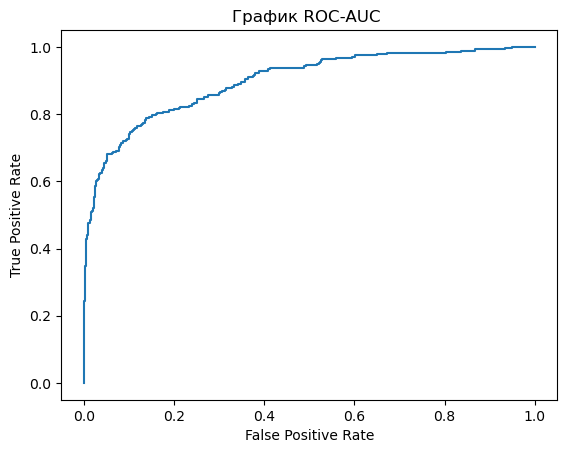


Метрика ROC-AUC лучшей модели на тестовой выборке: 0.8982
Метрика Accuracy лучшей модели на тестовой выборке: 0.8961


In [40]:
# качество на тестовой выборке
y_pred = lgbmr_best_model.predict(X_test)
y_proba = lgbmr_best_model.predict_proba(X_test)[:, 1]

# ROC-кривая
fpr, tpr, threshold = roc_curve(y_test, y_proba, pos_label=1)
plt.plot(fpr, tpr)
plt.title("График ROC-AUC ")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(f'\nМетрика ROC-AUC лучшей модели на тестовой выборке: {roc_auc_score(y_test, y_proba):.4f}')
print(f'Метрика Accuracy лучшей модели на тестовой выборке: {accuracy_score(y_test, y_pred):.4f}')

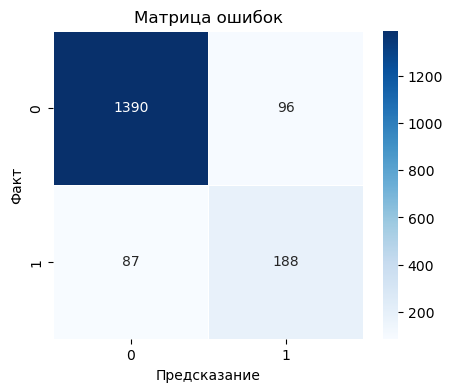

recall     = 0.684
precision  = 0.662


In [41]:
# матрица ошибок
cm = confusion_matrix(y_test, y_pred)

# построение тепловой карты
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel('Предсказание')
plt.ylabel('Факт')
plt.title('Матрица ошибок')
plt.show()

# метрики
print(f'{"recall":<10} = {recall_score(y_test, y_pred):.3f}')
print(f'{"precision":<10} = {precision_score(y_test, y_pred):.3f}')

- Метрика ROC-AUC на тестовой выборке составила 0.898, что выше порогового значения 0.85
- ROC-кривая расположена значительно выше диагонали случайной модели, что говорит о том, что модель хорошо различает клиентов, склонных к оттоку, и тех, кто остаётся
- Для задачи с дисбалансом классов accuracy не является основной метрикой, но значение 89.6 % подтверждает, что модель в целом хорошо справляется с классификацией
- Матрица ошибок показала, что модель хорошо справляется с определением доминирующего класса (клиенты, которые остаются). Однако наблюдается компромисс между полнотой и точностью:
  - recall = 0.68 — модель находит примерно 68% клиентов, которые действительно уходят, но часть всё же пропускает
  - precision = 0.66 — около трети клиентов, предсказанных как ушедшие, на самом деле остаются.

Для повышения качества выявления ушедших клиентов можно попробовать настроить порог вероятности принадлежности к классу

### Анализ важности признаков

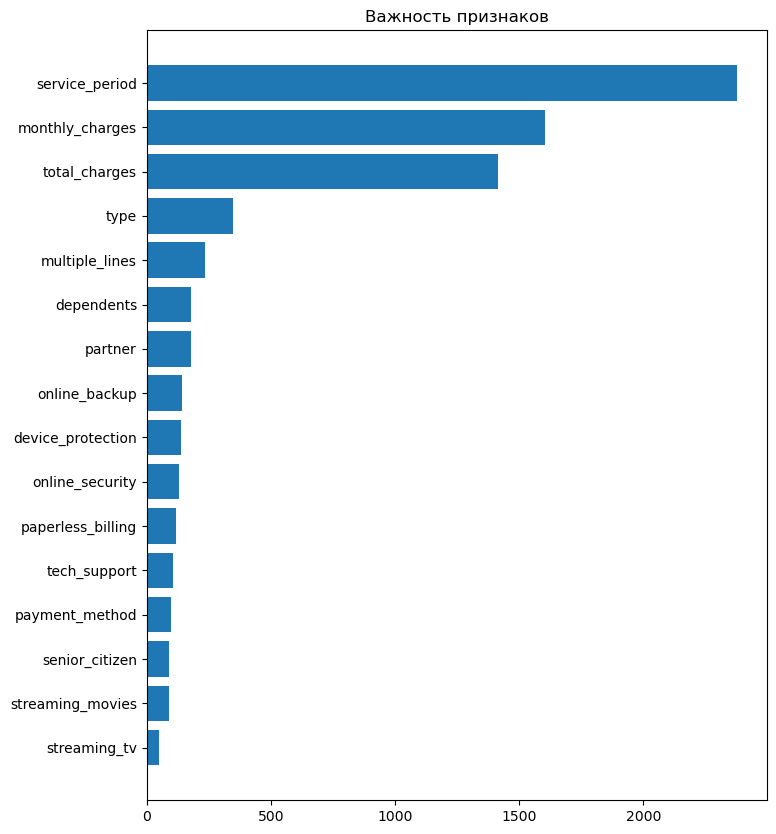

In [42]:
# Построение графика весов коэффициентов

coefs = pd.DataFrame(
    {'Feature': X_train.columns, 
     'Importance': lgbmr_best_model.best_estimator_.feature_importances_}
    ).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 10))
plt.barh(coefs['Feature'], coefs['Importance'])
plt.title('Важность признаков')
plt.show()

Анализ важности признаков показал, что наибольшее влияние на вероятность оттока оказывают: `service_period`; `monthly_charges`; `total_charges`. Наименее важным оказался признак `streaming_tv`.

## Шаг 8. Общий вывод и рекомендации заказчику

**Описание задачи**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

Цель проекта — разработать и обучить модель машинного обучения, которая будет прогнозировать отток клиентов компании «ТелеДом». Минимальный порог хорошей модели на кросс-валидации: ROC-AUC ≥ 0.85.

**Исходные данные и предобработка**
- Данные включали 4 таблицы: договоры (`contract_new.csv`), персональная информация (`personal_new.csv`), интернет-услуги (`internet_new.csv`), телефонные услуги (`phone_new.csv`). Всего объединенная таблица содержит 7043 строки. 
- Дубликатов в данных нет
- Типы данных приведены к корректным
- Добавлены новые признаки:
  - `churn` — отток, целевой признак 
  - `service_period` — срок обслуживания клиента
  - `has_internet`, `has_phone`, `has_family` — есть интернет, есть телефон, есть семья. После исследовательского анализа были исключены из модели, так как не показали свою значимость
- Пропуски были обработаны
  - в `total_charges` — заменены на 0, так как новые клиенты ещё не успели накопить расходы
  - в `internet_new.csv` — заменены на "No", чтобы показать, что услуга не подключена
  - в `phone_new.csv`— заменены на "missing", чтобы сохранить логический смысл значения «No», которое указывает, что телефон подключён только к одной линии.

**Исследовательский анализ**
- Целевая переменная несбалансирована (значительно больше оставшихся клиентов), что учтено при обучении (использовались веса классов)
- Распределения проверены, выбросы допустимы, так как отражают реальные бизнес-сценарии
- Портрет уходящего клиента: чаще уходят клиенты с более высоким сроком обслуживания, которые ежемесячно платят больше и, соответственно, имеют более высокие общие расходы. Договор у них заключен на 1–2 года, они чаще пенсионеры и/или семейные люди (имеют партнёра или детей). У таких клиентов подключён оптоволоконный интернет, как минимум одна дополнительная интернет-услуга и несколько телефонных линий одновременно
- Между `monthly_charges` и `internet_service` обнаружилась мультиколлинеарная связь. Признак `internet_service` был удален
- Признак `gender` также был удален, так как корреляция с целевым признаком отсутствует

**Моделирование**

Для задачи протестированы 3 модели:

| Модель                     | Время обучения (сек) | ROC-AUC (CV) |
| -------------------------- | -------------------- | ------------ |
| **LogisticRegression**     | 0.21 сек             | 0.77         |
| **RandomForestClassifier** | 2.87 сек             | 0.83         |
| **LGBMClassifier**         | 9.07 сек             | 0.89         |


Для финального применения выбрана модель `LGBMClassifier`. На кросс-валидации она показала ROC-AUC = 0.89, что полностью удовлетворяет целевому ограничению (ROC-AUC >= 0.85).

Сетка гиперпараметров для подбора:
- `'n_estimators': np.arange(25, 800, 25)`
- `'learning_rate': np.arange(0.05, 0.30, 0.05)`
- `'max_depth': range(5, 40)`

Лучшие гиперпараметры (по результатам RandomizedSearchCV):
- `n_estimators = 400`
- `learning_rate = 0.15`
- `max_depth = 5`

Результаты на тестовой выборке
- **ROC-AUC = 0.898** — модель хорошо различает уходящих и остающихся клиентов
- **Accuracy = 0.896** — подтверждает общую точность, хотя при дисбалансе классов эта метрика не ключевая
- **Recall = 0.68** — модель видит около 68% клиентов, которые действительно уходят
- **Precision = 0.66** — среди предсказанных ушедших 66% действительно уходят
- Матрица ошибок показала, что модель примерно в равной мере допускает как ложноотрицательные ошибки (пропуск ушедших клиентов), так и ложноположительные (ошибочная классификация лояльных клиентов как ушедших)

Анализ важности признаков показал, что наибольшее влияние на вероятность оттока оказывают: `service_period`; `monthly_charges`; `total_charges`. Наименее важным оказался признак `streaming_tv`.

**Рекомендации бизнесу**
- Модель на тестовых данных показала высокую эффективность. Для начала рекомендуется использовать её в пилотном режиме на части клиентской базы, чтобы проверить бизнес-эффект
- Совместно с маркетологами на этапе эксплуатации настроить порог классификации. Вместо фиксированного значения 0.5 использовать оптимальный порог, который учитывает бизнес-стоимость ошибок:
  - Ошибка I рода (ложноположительный) — клиент предсказан как ушедший, но остаётся, это лишние затраты на удержание
  - Ошибка II рода (ложноотрицательный) — клиент предсказан как лояльный, но уходит, это потеря клиента и упущенная прибыль
- Разработать персонализированные акции удержания для клиентов:
  - с высоким ежемесячным платежом
  - с долгим сроком обслуживания
  - с подключёнными дополнительными услугами
- Для дальнейшего улучшения модели можно рассмотреть добавление дополнительных данных, которые не были учтены в данном проекте, например:
  - обращения в техподдержку
  - уровень удовлетворённости клиента услугами
  - активность использования услуг (объём трафика, длительность звонков)

